In [2]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'serif', 'size':12}
plt.rc('font', **font)
plt.rc("lines", linewidth=3.0)
plt.rcParams["savefig.dpi"] = 500
cmap = plt.get_cmap('Spectral_r')

In [3]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

In [4]:
#1585673277 regr
#1585673319 GM classif
#1585729853 TS classif
#1587115375 NP plane 1hl
#1587367326 NP plane 3hl
#1588091638 ReLU
#1588503259 Tanh

paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
last = paths[-1]
path = last
path+='/'
print(path)

original_runs = []
for file in glob.glob(path + '*.pyT'):
    original_runs.append(torch.load(file))
original_params = torch.load(path+'params.pkl')
args = original_runs[0]['args']

print(original_runs[0]['args'],'\n')
for k, v in original_params.items():
    print(k,v)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

max_width=14

savedir= './figs/'+args.activation+'/'
#savedir= './figs/relu/'

r.1588753413/
Namespace(activation='relu', bs=1000000, d=200, depth=2, epochs=1000, epsilon=0.1, loss_type='mse', lr=0.01, mom=0.9, n=14384, n_classes=1, n_test=1000, name='001101', no_cuda=True, noise=0.5, num_seeds=5, task='regression', teacher_depth=2, teacher_width=100, test_noise=True, var=0.5, wd=0.0, width=8) 

width [   1    2    4    6    8   12   18   26   37   54   78  112  162  233
  335  483  695 1000]
activation ['relu']
noise [0, 0.5, 5]
lr [0.01]
n [    10     16     26     42     69    112    183    297    483    784
   1274   2069   3359   5455   8858  14384  23357  37926  61584 100000]
d [200]
num_seeds [5]
test_noise [False]
loss_type ['mse']
epochs [1000]
wd [0.0, 0.05]
depth [1, 2]


# Plotting

/home/dascoli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:924: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/dascoli/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/home/dascoli/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


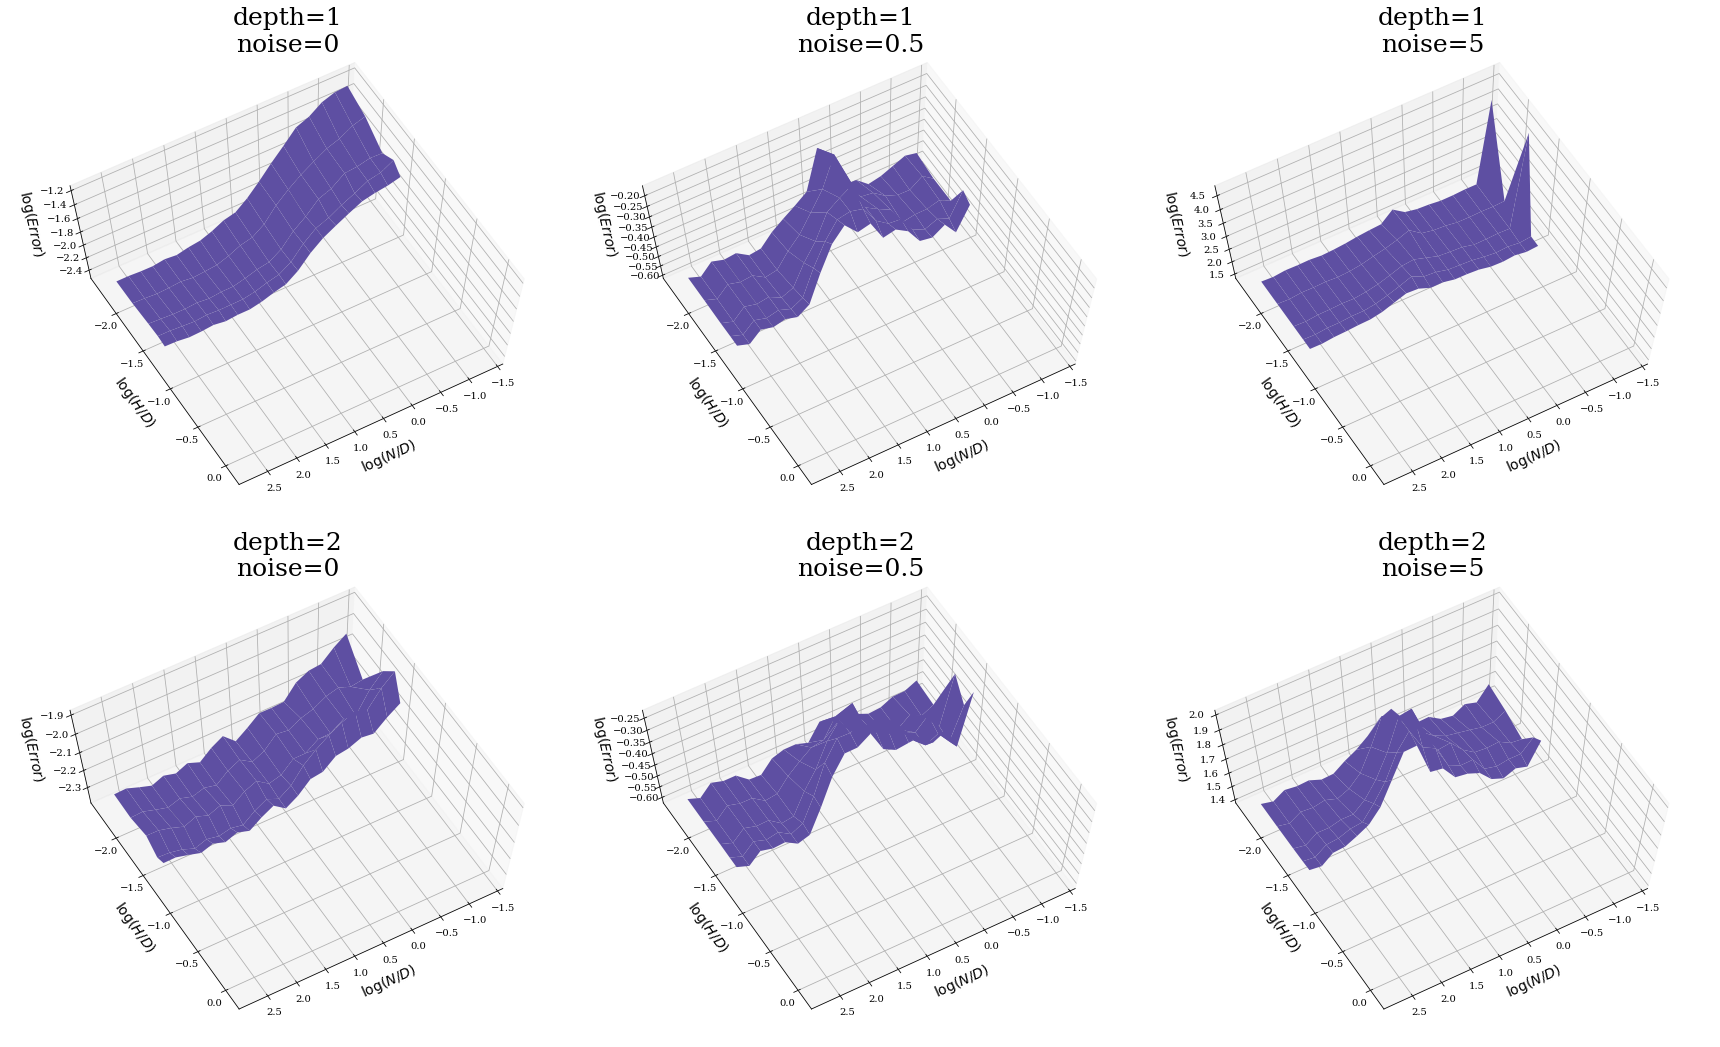

In [5]:
constraints = {}
constraints['wd'] = 0.0
runs, params = select_runs(original_runs, original_params, constraints)

var1='depth' #'noise'
var2='noise' #'noise'
ensembling=False
fig = plt.figure(figsize=(8*len(params[var2]),8*len(params[var1])))

grid = {'train_loss':np.zeros((len(params[var1]),len(params[var2]),len(params['n']),len(params['width']))),
       'test_loss':np.zeros((  len(params[var1]),len(params[var2]),len(params['n']),len(params['width']))),
       'test_error':np.zeros(( len(params[var1]),len(params[var2]),len(params['n']),len(params['width'])))}

for run in runs:
    args = run['args']
    i, j, k, l = find(params[var1],getattr(args,var1)), find(params[var2], getattr(args,var2)), find(params['n'],args.n), find(params['width'],args.width)
    
    train_loss =  run['tr_loss'][-1]
    if ensembling:
        test_loss =   run['te_loss_ens']
        test_error = 1-run['te_acc_ens']
    else:
        test_loss =   run['te_loss'][-1]
        test_error = 1-run['te_acc'][-1]
    
    grid['test_loss'] [i,j,k,l] = test_loss
    grid['train_loss'][i,j,k,l] = train_loss
    grid['test_error'][i,j,k,l] = test_error

for k in grid:
    grid[k]=grid[k][:,:,:,:max_width]
x, y = np.meshgrid(params['n'][:], params['width'][:max_width])

from itertools import product
for counter, (i,j) in enumerate(product(range(len(params[var1])),range(len(params[var2])))):
        ax = fig.add_subplot(len(params[var1]),len(params[var2]), counter+1,projection='3d')
        ax.plot_surface(np.log10(x/params['d']), np.log10(y/params['d']), np.log10(grid['test_loss'][i,j].T), cmap=cmap)
        ax.view_init(70, 60)
        #ax.set_title('{}={}, {}={}'.format(var1, params[var1][i], var2, params[var2][j]))
        ax.set_xlabel(r'$\log(N/D)$',     fontsize=14, labelpad=10)
        ax.set_ylabel(r'$\log(H/D)$',     fontsize=14, labelpad=10)
        ax.set_zlabel(r'$\log(Error)$',   fontsize=14, labelpad=10)
        #ax.set_zlim(top=2)
        ax.set_title('{}={}\n{}={}'.format(var1,params[var1][i], var2,params[var2][j]), pad=40, fontsize=25)
        #ax.set_zlim(0, 0.4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(savedir+'triple_descent_dnn.pdf')

# Dynamics

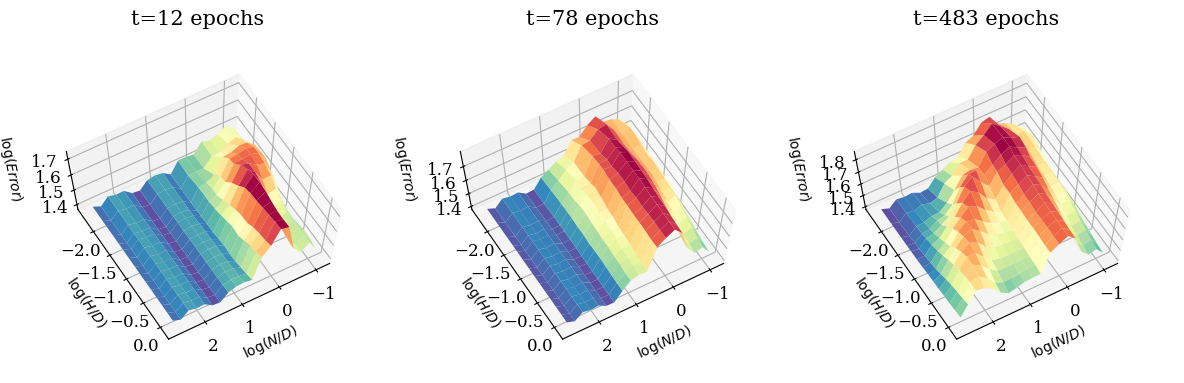

In [86]:
constraints = {}
constraints['wd'] = 0.0
constraints['noise'] = 5
constraints['depth'] = 1
runs, params = select_runs(original_runs, original_params, constraints)

original_steps = runs[0]['checkpoints']
steps = runs[0]['checkpoints'][5::5]

fig = plt.figure(figsize=(4*len(steps),4))
grid = {'train_loss':np.zeros((len(steps),len(params['n']),len(params['width']))),
       'test_loss':np.zeros((  len(steps),len(params['n']),len(params['width']))),
       'test_error':np.zeros(( len(steps),len(params['n']),len(params['width'])))}

for run in runs:
    args = run['args']
    i, j = find(params['n'],args.n), find(params['width'],args.width)
    
    for it,t in enumerate(steps):
        true_it = find(original_steps,t)
        train_loss =  run['tr_loss'][true_it]
        test_loss =   run['te_loss'][true_it]
        test_error = 1-run['te_acc'][true_it]
        grid['test_loss'] [it,i,j] = test_loss
        grid['train_loss'][it,i,j] = train_loss
        grid['test_error'][it,i,j] = test_error

for k in grid:
    grid[k]=grid[k][:,1:,:max_width]
x, y = np.meshgrid(params['n'][1:], params['width'][:max_width])

from itertools import product
for it in range(len(steps)):
    ax = fig.add_subplot(1,len(steps), it+1,projection='3d')
    ax.plot_surface(np.log10(x/params['d']), np.log10(y/params['d']), np.log10(grid['test_loss'][it].T), cmap=cmap)
    ax.view_init(70, 60)
    ax.set_xlabel(r'$\log(N/D)$',     fontsize=10, labelpad=10)
    ax.set_ylabel(r'$\log(H/D)$',     fontsize=10, labelpad=10)
    ax.set_zlabel(r'$\log(Error)$',   fontsize=10, labelpad=10)
    #ax.set_zlim(top=2)
    ax.set_title('t={0:.0f} epochs'.format(steps[it]), pad=40, fontsize=15)
    ax.dist=11


plt.tight_layout()
plt.savefig(savedir+'dynamics.pdf')

# Regularizing

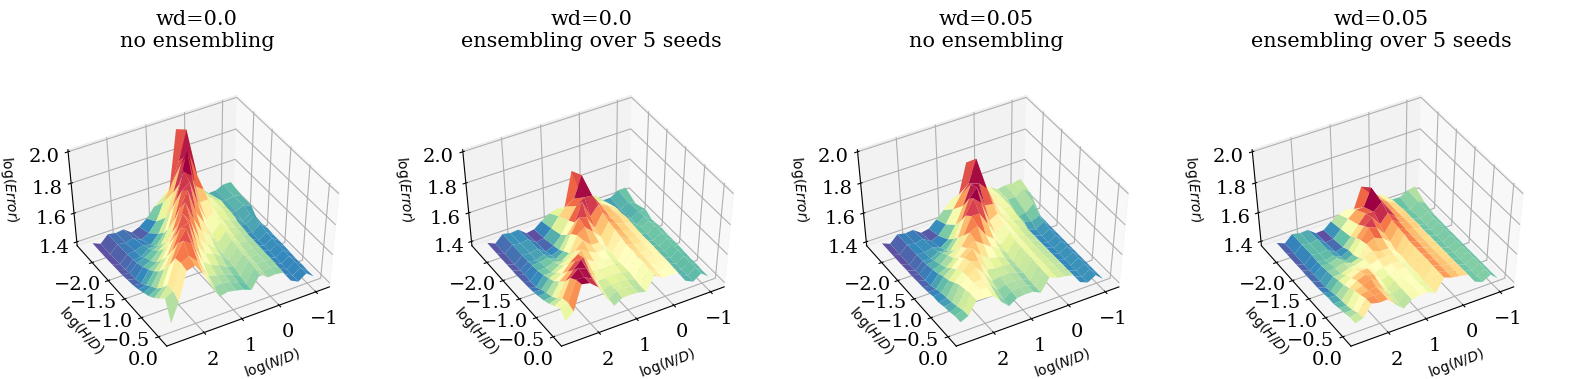

In [43]:
constraints = {}
constraints['noise'] = 5
constraints['depth'] = 1
runs, params = select_runs(original_runs, original_params, constraints)

var1='wd' #'noise'
ensembling=False
fig = plt.figure(figsize=(4*2*len(params[var1]),4))

grid = {'train_loss':np.zeros((len(params[var1]),2,len(params['n']),len(params['width']))),
       'test_loss':np.zeros((  len(params[var1]),2,len(params['n']),len(params['width']))),
       'test_error':np.zeros(( len(params[var1]),2,len(params['n']),len(params['width'])))}

for iens, ensembling in enumerate([False,True]):
    for run in runs:
        args = run['args']
        i, j, k = find(params[var1],getattr(args,var1)), find(params['n'],args.n), find(params['width'],args.width)

        train_loss =  run['tr_loss'][-1]
        if ensembling:
            test_loss =   run['te_loss_ens']
            test_error = 1-run['te_acc_ens']
        else:
            test_loss =   run['te_loss'][-1]
            test_error = 1-run['te_acc'][-1]

        grid['test_loss'] [i,iens,j,k] = test_loss
        grid['train_loss'][i,iens,j,k] = train_loss
        grid['test_error'][i,iens,j,k] = test_error

#widths = widths[:15]
for k in grid:
    grid[k]=grid[k][:,:,:,:max_width]
x, y = np.meshgrid(params['n'][:], params['width'][:maw_width])

from itertools import product
for counter, (i,j) in enumerate(product(range(len(params[var1])),range(2))):
        ax = fig.add_subplot(1,len(params[var1])*2, counter+1,projection='3d')
        ax.plot_surface(np.log10(x/params['d']), np.log10(y/params['d']), np.log10(grid['test_loss'][i,j].T), cmap=cmap)
        ax.view_init(50, 60)
        ax.set_xlabel(r'$\log(N/D)$',     fontsize=10, labelpad=10)
        ax.set_ylabel(r'$\log(H/D)$',     fontsize=10, labelpad=10)
        ax.set_zlabel(r'$\log(Error)$',   fontsize=10, labelpad=10)
        ax.set_zlim(top=2)
        ax.set_title('{}={}\n'.format(var1,params[var1][i])+('no ensembling' if j==0 else 'ensembling over 5 seeds'), pad=40, fontsize=15)
        #ax.set_zlim(top=2)
        ax.dist=11

plt.tight_layout()
plt.savefig(savedir+'regularizing_dnn.pdf',bbox_inches='tight')

# Select a single run

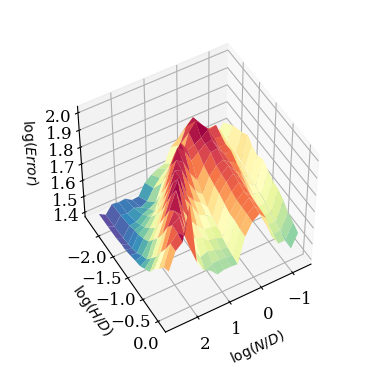

In [110]:
constraints = {}
constraints['wd'] = 0.
constraints['noise'] = 5
constraints['depth'] = 2
ensembling=False

runs, params = select_runs(original_runs, original_params, constraints)

fig = plt.figure(figsize=(4,4))
grid = {'train_loss':np.zeros((len(params['n']),len(params['width']))),
       'test_loss':np.zeros((  len(params['n']),len(params['width']))),
       'test_error':np.zeros(( len(params['n']),len(params['width'])))}

for run in runs:
    args = run['args']
    i, j = find(params['n'],args.n), find(params['width'],args.width)
    if ensembling:
        test_loss =   run['te_loss_ens']
        test_error = 1-run['te_acc_ens']
    else:
        train_loss =  run['tr_loss'][-1]
        test_loss =   run['te_loss'][-1]
        test_error = 1-run['te_acc'][-1]
    grid['test_loss'] [i,j] = test_loss
    grid['train_loss'][i,j] = train_loss
    grid['test_error'][i,j] = test_error

for k in grid:
    grid[k]=grid[k][:,:max_width]
x, y = np.meshgrid(params['n'][:], params['width'][:max_width])

from itertools import product
for it in range(len(steps)):
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(np.log10(x/params['d']), np.log10(y/params['d']), np.log10(grid['test_loss'].T), cmap=cmap)
    ax.view_init(50, 60)
    ax.set_xlabel(r'$\log(N/D)$',     fontsize=10, labelpad=10)
    ax.set_ylabel(r'$\log(H/D)$',     fontsize=10, labelpad=10)
    ax.set_zlabel(r'$\log(Error)$',   fontsize=10, labelpad=10)
    #ax.set_zlim(top=1.8)
    ax.dist=12


plt.tight_layout()
plt.savefig(savedir+'ens_{}_depth_{}_wd_{}_noise_{}.pdf'.format(ensembling, constraints['depth'], constraints['wd'], constraints['noise']))